# 3D Convolutional Neural Network

# Setup (data path is set up here)

In [0]:
#### Our imports ####

from google.colab import drive
import h5py
from torch.utils.data import Dataset
import pdb
from sklearn.metrics import confusion_matrix
import warnings

#### From SR ####

import os
import time
import math

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image




if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [0]:
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
DATA_PATH = '/gdrive/Team Drives/479 group project/Data_aug/'

#Data augmentation

Only run this if more data is necessary. Augmented data is already in Data_aug folder.

In [0]:
import sys
sys.path.append(DATA_PATH)
from voxelgrid import VoxelGrid

NameError: ignored

## Rotation and adding-noise Functions 

In [0]:
def Rx(angle, degrees=True):
    """ 
    """
    if degrees:
        
        cx = np.cos(np.deg2rad(angle))
        sx = np.sin(np.deg2rad(angle))
        
    else:
        
        cx = np.cos(angle)
        sx = np.sin(angle)
        
    Rx = np.array(
    [[1  , 0  , 0  ],
     [0  , cx , sx ],
     [0  , -sx, cx]]
    )
    
    return Rx
  
def Ry(angle, degrees=True):
    
    if degrees:
        
        cy = np.cos(np.deg2rad(angle))
        sy = np.sin(np.deg2rad(angle))
        
    else:
        
        cy = np.cos(angle)
        sy = np.sin(angle)
        
    Ry = np.array(
    [[cy , 0  , -sy],
     [0  , 1  , 0  ],
     [sy , 0  , cy]]
    )
    
    return Ry 
  
def Rz(angle, degrees=True):
        
    if degrees:
        
        cz = np.cos(np.deg2rad(angle))
        sz = np.sin(np.deg2rad(angle))
        
    else:
        
        cz = np.cos(angle)
        sz = np.sin(angle)
        
    Rz = np.array(
    [[cz , sz , 0],
     [-sz, cz , 0],
     [0  , 0  , 1]]
    )
        
    return Rz  
def add_noise(xyz, strength=0.25):
    std = xyz.std(0) * strength
    noise = np.zeros_like(xyz)
    for i in range(3):
        noise[:,i] += np.random.uniform(-std[i], std[i], xyz.shape[0])
    return xyz + noise    

## Creating more data

In [0]:
def augmenting_data(name,num_newdata):
  if name == 'train':
        prefix = 'train'
  elif name == 'test':
        prefix = 'test'
  else:
        raise ValueError('name must be one of {train, test}.')
  
  
  with h5py.File(DATA_PATH + prefix+"_point_clouds.h5", "r") as hf:
      curr_size = len(hf.keys())
      added_size = num_newdata  
      aug_x = []
      aug_y = []
      print('augmenting {}ing'.format(prefix),'data...')
      for i in range(added_size):
          if len(aug_x) % 2000 == 0:
              print(len(aug_x),"/ {}".format(added_size+curr_size), "\t processed")

          # traverse the current data multiple times    
          original_cloud = hf[str(i%curr_size)]["points"][:]
          label = hf[str(i%curr_size)].attrs["label"]

          if i <= curr_size - 1:
            voxelgrid = VoxelGrid(original_cloud, x_y_z=[16, 16, 16])
            vector = voxelgrid.vector.reshape(-1) / np.max(voxelgrid.vector)  
            vector = np.array(vector)

            aug_x.append(vector)
            aug_y.append(np.int64(label))

          s_x = np.random.normal(0, 90)
          s_y = np.random.normal(0, 90)
          s_z = np.random.normal(0, 180)

          cloud = original_cloud @ Rz(s_z) @ Ry(s_y) @ Rx(s_x)

          cloud = add_noise(cloud)

          voxelgrid = VoxelGrid(cloud, x_y_z=[16, 16, 16])

          vector = voxelgrid.vector.reshape(-1) / np.max(voxelgrid.vector)
          vector = np.array(vector)



          aug_x.append(vector)
          aug_y.append(np.int64(label))

      print("[DONE]")
      return aug_x,aug_y

In [0]:
num_newtest = 2000
num_newtrain = 20000

In [0]:
X_aug_train,y_aug_train = augmenting_data("train",num_newtrain)
X_aug_test,y_aug_test = augmenting_data("test",num_newtest)

0 / 25000 	 processed
2000 / 25000 	 processed
4000 / 25000 	 processed
6000 / 25000 	 processed
8000 / 25000 	 processed
10000 / 25000 	 processed
12000 / 25000 	 processed
14000 / 25000 	 processed
16000 / 25000 	 processed
18000 / 25000 	 processed
20000 / 25000 	 processed
22000 / 25000 	 processed
24000 / 25000 	 processed
[DONE]
0 / 3000 	 processed
2000 / 3000 	 processed
[DONE]


## saving new data to h5py file

In [0]:
def saving_augmented_data(name,new_X,new_y):
  if name == 'train':
        suffix = '_aug_train'
  elif name == 'test':
        suffix = '_aug_test'
  else:
        raise ValueError('name must be one of {train, test}.')
      
  with h5py.File(DATA_PATH + 'full_dataset_vectors.h5', 'a') as hf:
    if 'X'+suffix in hf.keys() and 'y'+suffix in hf.keys():
      del hf['X'+suffix]
      del hf['y'+suffix]
      hf.create_dataset('X'+suffix,data=new_X)
      hf.create_dataset('y'+suffix,data=new_y)
    elif not('X'+suffix in hf.keys()) and not('y'+suffix in hf.keys()):
      hf.create_dataset('X'+suffix,data=new_X)
      hf.create_dataset('y'+suffix,data=new_y)
    else:
      raise ValueError('something went wrong')  
    print('X'+suffix,'has {}'.format(len(hf['X'+suffix])),'instances')
    print('y'+suffix,'has {}'.format(len(hf['y'+suffix])),'instances')
      
    

In [0]:
saving_augmented_data('test',X_aug_test,y_aug_test)
saving_augmented_data('train',X_aug_train,y_aug_train)

X_aug_test has 3000 images
y_aug_test has 3000 images
X_aug_train has 25000 images
y_aug_train has 25000 images


#Baseline of Test Accuracy (Logistic, Random Forest, and KNN)


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [0]:
hf =  h5py.File(DATA_PATH + 'full_dataset_vectors.h5', 'a') 
train_x = hf['X_aug_train']
train_y = hf['y_aug_train']
test_x = hf['X_aug_test']
test_y = hf['y_aug_test']
  

Logistic 

In [0]:
with warnings.catch_warnings():
  warnings.filterwarnings("ignore")
  start_time = time.time()
  reg = LogisticRegression()
  reg.fit(train_x,train_y)
  print('Training time: ',(time.time()-start_time)/60)
  print("Accuracy: ", reg.score(test_x,test_y))
  

Training time:  6.441720418135325
Accuracy:  0.5263333333333333


Random Forest

In [0]:
with warnings.catch_warnings():
  warnings.filterwarnings('ignore')
  start_time = time.time()
  RF = RandomForestClassifier()
  print(RF)
  RF.fit(train_x,train_y)
  print('Training time: ',(time.time()-start_time)/60)
  print("Accuracy: ", RF.score(test_x,test_y))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Training time:  0.11287728548049927
Accuracy:  0.521


KNN 

In [0]:
with warnings.catch_warnings():
  warnings.filterwarnings('ignore')
  start_time = time.time()
  knn = KNeighborsClassifier()
  knn.fit(train_x, train_y)
  print('Training time: ',(time.time()-start_time)/60)
  print("Accuracy: ", knn.score(test_x,test_y))

Training time:  0.29697930415471396
Accuracy:  0.5526666666666666


# Model Settings

In [0]:
#-------------------------
### SETTINGS
#-------------------------

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 30

# Architecture
NUM_FEATURES = 16*16*16
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Dataset : [3D MNIST](https://www.kaggle.com/daavoo/3d-mnist)

## Custom `Dataset` 

In [0]:
# Transform data from 1d to 3d rgb
def rgb_data_transform(data):

  data_t = []
  for i in range(data.shape[0]):
    data_t.append(array_to_color(data[i]).reshape(16, 16, 16, 3))

  return np.asarray(data_t, dtype=np.float32)


# 1D vector to rgb values, provided by plot3d.py
def array_to_color(array, cmap="Oranges"):

  s_m = plt.cm.ScalarMappable(cmap=cmap)

  return s_m.to_rgba(array)[:,:-1]
    

class MNIST(Dataset):
    
    def __init__(self, name, transform = None):
      """ 
      - Inputs are scaled to [0, 1]
      - Input is 4D [n, 16, 16, 16, 3] array. 
      """
      
      if name == 'train':
        suffix = '_train'
      elif name == 'validation' or name == 'test':
        suffix = '_test'
      elif name == 'aug_train':
        suffix = '_aug_train'
      elif name == 'aug_validation' or name == 'aug_test':
        suffix = '_aug_test'
      else:
        raise ValueError('name must be one of {train, validation, test,aug_train,aug_validation,aug_test}.')
        
      with h5py.File(DATA_PATH + 'full_dataset_vectors.h5', 'r') as hf:
        X = np.swapaxes(rgb_data_transform(hf['X' + suffix][:]), 1, 4)
        Y = hf['y' + suffix][:]
        if name == 'validation' or name == 'test' or name == 'aug_validation' or name == 'aug_test':
          np.random.seed(RANDOM_SEED)
          all_i = np.array([i for i in range(X.shape[0])])
          np.random.shuffle(all_i)
          #subsets = np.array_split(all_i, [math.floor(0.8*all_i.shape[0])])
          #print(len(subsets[0]))
          #print(len(subsets[1]))
          valid_i, test_i = np.split(all_i,2)
          #print(valid_i,test_i)
          #valid_i,test_i = subsets[0],subsets[1]
         
          #print(len(test_i))
          if name == 'validation'or name == 'aug_validation':
            self.X = X[valid_i, :]
            self.Y = Y[valid_i]
          else:
            self.X = X[test_i, :]
            self.Y = Y[test_i]
        else:
          self.X = X
          self.Y = Y
        
      self.transform = transform
      self.name = name
    
    def __getitem__(self, index):
      
      img = self.X[index, :, :, :, :]
      
      if self.transform is not None:
        data = self.transform(img)
        
      label = self.Y[index]
      
      return img, label
     
    def __len__(self):
      
      return len(self.Y)

## Loading the Data

In [0]:
train_dataset = MNIST('aug_train')
valid_dataset = MNIST('aug_validation')
test_dataset = MNIST('aug_test')
#train_dataset = MNIST('train')
#valid_dataset = MNIST('validation')
#test_dataset = MNIST('test')


In [0]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          num_workers=8,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset,
                         batch_size=BATCH_SIZE,
                         num_workers=8,
                         shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=8,
                         shuffle=False)

# Checking the train dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
print('Train set has', train_dataset.__len__(), 'instances.')

# Checking the validation dataset
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
print('validation set has', valid_dataset.__len__(), 'instances.')

# Checking the test dataset
for images, labels in test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
print('Test set has', test_dataset.__len__(), 'instances.')

Image batch dimensions: torch.Size([128, 3, 16, 16, 16])
Image label dimensions: torch.Size([128])
Train set has 25000 instances.
Image batch dimensions: torch.Size([128, 3, 16, 16, 16])
Image label dimensions: torch.Size([128])
validation set has 1500 instances.
Image batch dimensions: torch.Size([128, 3, 16, 16, 16])
Image label dimensions: torch.Size([128])
Test set has 1500 instances.


# Training and Evaluation Functions

## Confusion Matrix

---



In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Compute Loss and Accuracy

In [0]:
###############################
### NO NEED TO CHANGE THIS CELL
###############################

def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss


def compute_accuracy(model, data_loader, device, show_confusion = False):
    model.eval()
    correct_pred, num_examples = 0, 0
    full_targets = None
    full_predictions = None
    for i, (features, targets) in enumerate(data_loader):
        
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
    # My edit: displaying confusion matrix
        if show_confusion:
          if full_targets is None and full_predictions is None:
              full_targets = targets
              full_predictions = predicted_labels
          else:
              full_targets = torch.cat((full_targets, targets))
              full_predictions = torch.cat((full_predictions, predicted_labels))
    if show_confusion:
        full_targets = full_targets.data.cpu().numpy()
        full_predictions = full_predictions.data.cpu().numpy()
        cm = plot_confusion_matrix(y_true = full_targets,
                                   y_pred = full_predictions,
                                  classes = [i for i in range(10)])
    
    return correct_pred.float()/num_examples * 100

## Training

In [0]:
###############################
### NO NEED TO CHANGE THIS CELL
###############################

def train(model, train_loader, valid_loader,test_loader,valid_per):

    minibatch_cost, epoch_cost,valid_history = [],[],[]
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            cost = F.cross_entropy(logits, targets)
            optimizer.zero_grad()

            cost.backward()
            minibatch_cost.append(cost)

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 150:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx, 
                         len(train_loader), cost))

    
        with torch.set_grad_enabled(False): # save memory during inference
            print('Epoch: %03d/%03d | Train: %.3f%%' % (
                  epoch+1, NUM_EPOCHS, 
                  compute_accuracy(model, train_loader, device=DEVICE)))
          
            # ME: showing validation accuracy 
            if not ((epoch+1) % valid_per):
              valid_curr = compute_accuracy(model, valid_loader, device=DEVICE)
              valid_history.append(valid_curr)
              print('Validation: %.2f%%' % (valid_curr))
             # print('Validation: %.2f%%' % (
                  #compute_accuracy(model, valid_loader, device=DEVICE)))
            
            cost = compute_epoch_loss(model, train_loader)
            epoch_cost.append(cost)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


    with torch.set_grad_enabled(False): # save memory during inference
        print('Final Validation accuracy: %.2f%%' % (
            compute_accuracy(model, valid_loader, device=DEVICE)))
        
    with torch.set_grad_enabled(False): # save memory during inference
        print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))    

    print('Total Time: %.2f min' % ((time.time() - start_time)/60))
    
    return minibatch_cost, epoch_cost,valid_history

## Parameter Summary Function

In [0]:
def show_params(model):
  sum = 0
  for name, param in model.named_parameters():
      if param.requires_grad:
          print(name, param.numel())
          sum = sum + param.numel()
  print("Total Trainable Parameters =", sum)

# Original

## Architecture

In [0]:
conv_D_rate = 0.2
fc_D_rate = 0.5
valid_per = 3

Create an instance of Original class to initialize the model


In [0]:
class Original(nn.Module):

    def __init__(self, num_classes=10):
        super(Original, self).__init__()  
        
        self.conv1 = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        
        self.conv2 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.Dropout3d(p = conv_D_rate),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        
        self.conv3 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.Dropout3d(p = conv_D_rate),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        
        self.conv4 = nn.Sequential(
            nn.Conv3d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm3d(512),
            nn.Dropout3d(p = conv_D_rate),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        
        self.fc1 = nn.Sequential(
            nn.Linear(512, 256),  # 512 output nodes before
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p = fc_D_rate))
        
        self.fc2 = nn.Sequential(
            nn.Linear(256, num_classes)) # 512 output nodes before
        
        self._convolutions = nn.Sequential(
            self.conv1,
            self.conv2,
            self.conv3,
            self.conv4)

        self._classifier = nn.Sequential(
            self.fc1,
            self.fc2)
        

    def forward(self, x):
        
        out = self._convolutions(x)
        out = out.view(-1, 512)
        out = self._classifier(out)
        
        logits = out
        probas = F.softmax(logits, dim=1)
        
        return logits, probas


original = Original(NUM_CLASSES)
original.to(DEVICE)

optimizer = torch.optim.Adam(original.parameters(), lr=LEARNING_RATE)  

In [0]:
show_params(original)

conv1.0.weight 5184
conv1.0.bias 64
conv2.0.weight 221184
conv2.0.bias 128
conv2.1.weight 128
conv2.1.bias 128
conv3.0.weight 884736
conv3.0.bias 256
conv3.1.weight 256
conv3.1.bias 256
conv4.0.weight 3538944
conv4.0.bias 512
conv4.1.weight 512
conv4.1.bias 512
fc1.0.weight 131072
fc1.0.bias 256
fc1.1.weight 256
fc1.1.bias 256
fc2.0.weight 2560
fc2.0.bias 10
Total Trainable Parameters = 4787210


## Training



Epoch: 001/030 | Batch 0000/0196 | Cost: 2.3652
Epoch: 001/030 | Batch 0150/0196 | Cost: 1.6526
Epoch: 001/030 | Train: 43.756%
Time elapsed: 0.43 min
Epoch: 002/030 | Batch 0000/0196 | Cost: 1.6222
Epoch: 002/030 | Batch 0150/0196 | Cost: 1.3346
Epoch: 002/030 | Train: 50.180%
Time elapsed: 0.88 min
Epoch: 003/030 | Batch 0000/0196 | Cost: 1.4712
Epoch: 003/030 | Batch 0150/0196 | Cost: 1.1835
Epoch: 003/030 | Train: 62.120%
Validation: 64.80%
Time elapsed: 1.35 min
Epoch: 004/030 | Batch 0000/0196 | Cost: 1.1032
Epoch: 004/030 | Batch 0150/0196 | Cost: 1.1893
Epoch: 004/030 | Train: 62.356%
Time elapsed: 1.79 min
Epoch: 005/030 | Batch 0000/0196 | Cost: 0.9265
Epoch: 005/030 | Batch 0150/0196 | Cost: 0.9655
Epoch: 005/030 | Train: 67.668%
Time elapsed: 2.24 min
Epoch: 006/030 | Batch 0000/0196 | Cost: 0.7574
Epoch: 006/030 | Batch 0150/0196 | Cost: 0.9548
Epoch: 006/030 | Train: 76.644%
Validation: 73.87%
Time elapsed: 2.70 min
Epoch: 007/030 | Batch 0000/0196 | Cost: 0.6975
Epoch: 0

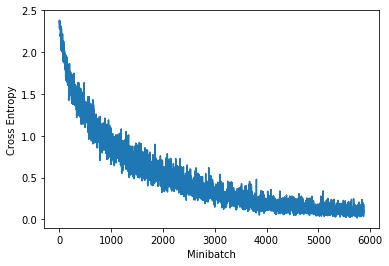

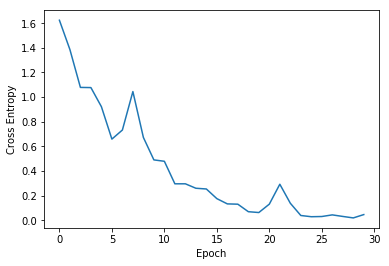

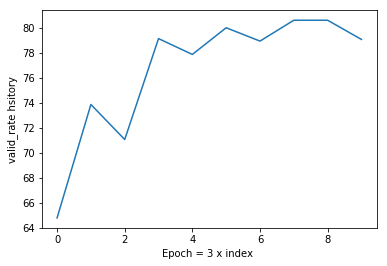

In [0]:
# Hyperparameters
#BATCH_SIZE = 128
#NUM_EPOCHS = 4

minibatch_cost, epoch_cost,valid_history = train(original, train_loader, valid_loader,test_loader,valid_per = valid_per)

plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

plt.plot(range(len(valid_history)), valid_history)
plt.ylabel('valid_rate hsitory')
plt.xlabel('Epoch = {} x index '.format(valid_per))
plt.show()


## Testing

Test Accuracy (%) = 79.399994


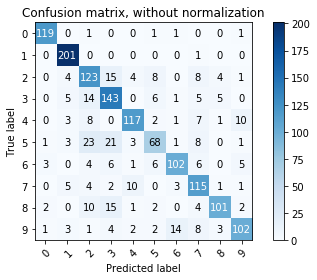

In [0]:
print("Test Accuracy (%) =",
      compute_accuracy(original, test_loader, DEVICE, show_confusion = True).data.cpu().numpy())

# Connectomes
From [this](https://arxiv.org/pdf/1806.04209.pdf) source.

In [0]:

valid_per = 3

## Architecture

In [0]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        print(x.shape)
        return x

class Connectomes(nn.Module):

    def __init__(self, num_classes=10):
        super(Connectomes, self).__init__()  
        
        self._conv = nn.Sequential(
            nn.AvgPool3d(kernel_size=(2, 2, 2), stride = (2, 2, 2)),
            nn.Conv3d(3, 128, kernel_size=3, padding=1),
            nn.ELU(),
            nn.Conv3d(128, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.Conv3d(32, 32, kernel_size=3, padding=1),  # New (this and below)
            nn.ELU(),
            nn.MaxPool3d(kernel_size=(8, 8, 8), stride=(8, 8, 8))) # Different but required
        
        self._fc = nn.Sequential(
            nn.Linear(32, 32),
            nn.ELU(),
            nn.Linear(32, num_classes))
        

    def forward(self, x):
        
        out = self._conv(x)
        out = out.view(-1, 32)
        out = self._fc(out)
        
        logits = out
        probas = F.softmax(logits, dim=1)
        
        return logits, probas


connectomes = Connectomes(NUM_CLASSES)
connectomes.to(DEVICE)

optimizer = torch.optim.Adam(connectomes.parameters(), lr=LEARNING_RATE)

Number of Parameters

In [0]:
show_params(connectomes)

_conv.1.weight 10368
_conv.1.bias 128
_conv.3.weight 110592
_conv.3.bias 32
_conv.5.weight 27648
_conv.5.bias 32
_fc.0.weight 1024
_fc.0.bias 32
_fc.2.weight 320
_fc.2.bias 10
Total Trainable Parameters = 150186


## Training

Epoch: 001/030 | Batch 0000/0196 | Cost: 2.2979
Epoch: 001/030 | Batch 0150/0196 | Cost: 1.9480
Epoch: 001/030 | Train: 35.732%
Time elapsed: 0.28 min
Epoch: 002/030 | Batch 0000/0196 | Cost: 1.8586
Epoch: 002/030 | Batch 0150/0196 | Cost: 1.8142
Epoch: 002/030 | Train: 44.756%
Time elapsed: 0.56 min
Epoch: 003/030 | Batch 0000/0196 | Cost: 1.4149
Epoch: 003/030 | Batch 0150/0196 | Cost: 1.5122
Epoch: 003/030 | Train: 51.016%
Validation: 54.67%
Time elapsed: 0.86 min
Epoch: 004/030 | Batch 0000/0196 | Cost: 1.3345
Epoch: 004/030 | Batch 0150/0196 | Cost: 1.1173
Epoch: 004/030 | Train: 55.748%
Time elapsed: 1.14 min
Epoch: 005/030 | Batch 0000/0196 | Cost: 1.2520
Epoch: 005/030 | Batch 0150/0196 | Cost: 1.1748
Epoch: 005/030 | Train: 58.664%
Time elapsed: 1.42 min
Epoch: 006/030 | Batch 0000/0196 | Cost: 1.1767
Epoch: 006/030 | Batch 0150/0196 | Cost: 1.2820
Epoch: 006/030 | Train: 61.692%
Validation: 62.53%
Time elapsed: 1.71 min
Epoch: 007/030 | Batch 0000/0196 | Cost: 1.1939
Epoch: 0

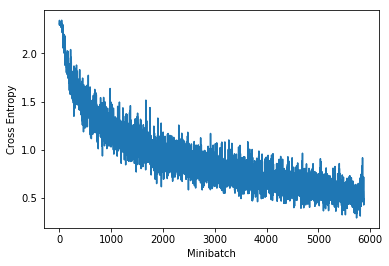

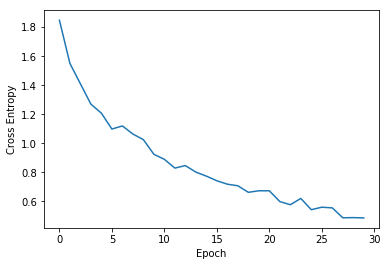

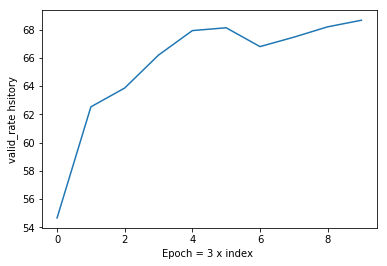

In [0]:

minibatch_cost, epoch_cost,valid_history = train(connectomes, train_loader, valid_loader,test_loader,valid_per = valid_per)

plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

plt.plot(range(len(valid_history)), valid_history)
plt.ylabel('valid_rate hsitory')
plt.xlabel('Epoch = {} x index '.format(valid_per))
plt.show()


## Testing

Test Accuracy (%) = 70.200005


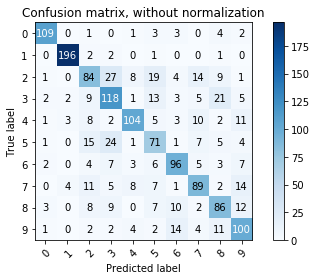

In [0]:
print("Test Accuracy (%) =",
      compute_accuracy(connectomes, test_loader, DEVICE, show_confusion = True).data.cpu().numpy())

# All Convolutional

## Architecture


In [0]:
drop_rate = 0.2
drop_rate2 = 0.5 

In [0]:
class allconv(nn.Module):

    def __init__(self, num_classes=10):
        super(allconv, self).__init__()  
        
         #16x16X16X3 => 16x16x16x64
        self.conv1 = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=3, padding=1),
            nn.ReLU())
        
        #16x16x16x64 => 8x8x8x64
        self.conv15 = nn.Sequential(
            nn.Conv3d(64, 64, kernel_size=3, padding=1,stride=2),
            nn.ReLU())
        
        #8x8x8x64 => 8x8x8x128
        self.conv2 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.Dropout3d(p =drop_rate),
            nn.ReLU())
        
        #8x8x8x128 => 4x4x4x128
        self.conv25 = nn.Sequential(
            nn.Conv3d(128, 128, kernel_size=3, padding=1,stride=2),
            nn.BatchNorm3d(128),
            nn.Dropout3d(p =drop_rate),
            nn.ReLU())
        
        #4x4x4x128 => 4x4x4x256
        self.conv3 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.Dropout3d(p =drop_rate),
            nn.ReLU())
        
        #4x4x4x256 => 2x2x2x256
        self.conv35 = nn.Sequential(
            nn.Conv3d(256, 256, kernel_size=3, padding=1,stride = 2),
            nn.BatchNorm3d(256),
            nn.Dropout3d(p =drop_rate),
            nn.ReLU())
        
        #2x2x2x256 => 2x2x2x512
        self.conv4 = nn.Sequential(
            nn.Conv3d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm3d(512),
            nn.Dropout3d(p =drop_rate),
            nn.ReLU())
        
        #2x2x2x512 => 1x1x1x512
        self.conv45 = nn.Sequential(
            nn.Conv3d(512, 512, kernel_size=3, padding=1,stride=2),
            nn.BatchNorm3d(512),
            nn.Dropout3d(p =drop_rate),
            nn.ReLU())
        
        #1x1x1x512
        '''
        self.conv5 = nn.Sequential(
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm3d(512),
            nn.Dropout3d(p = 0.2),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        '''
        
        self.conv5 = nn.Sequential(
            nn.Conv3d(512, 256, kernel_size=1,stride=1),
            nn.BatchNorm3d(256),
            nn.Dropout3d(p =drop_rate2),
            nn.ReLU())
       
        self.conv6 = nn.Sequential(
            nn.Conv3d(256, NUM_CLASSES, kernel_size=1,stride=1),
            nn.BatchNorm3d(NUM_CLASSES),
            nn.ReLU()) 
        self._convolutions = nn.Sequential(
            self.conv1,
            self.conv15,
            self.conv2,
            self.conv25,
            self.conv3,
            self.conv35,
            self.conv4,
            self.conv45,            
            self.conv5,
            self.conv6)

        

    def forward(self, x):
        
        out = self._convolutions(x)
        logits = out
        logits = F.adaptive_avg_pool3d(out,1)
        logits.squeeze_(-1)
        logits.squeeze_(-1)
        logits.squeeze_(-1)
        probas = torch.softmax(logits, dim=1)
        
        return logits, probas


allconv = allconv(NUM_CLASSES)
allconv.to(DEVICE)

optimizer = torch.optim.Adam(allconv.parameters(), lr=LEARNING_RATE)  

##Training


Number of parameter

In [0]:
show_params(allconv)

conv1.0.weight 5184
conv1.0.bias 64
conv15.0.weight 110592
conv15.0.bias 64
conv2.0.weight 221184
conv2.0.bias 128
conv2.1.weight 128
conv2.1.bias 128
conv25.0.weight 442368
conv25.0.bias 128
conv25.1.weight 128
conv25.1.bias 128
conv3.0.weight 884736
conv3.0.bias 256
conv3.1.weight 256
conv3.1.bias 256
conv35.0.weight 1769472
conv35.0.bias 256
conv35.1.weight 256
conv35.1.bias 256
conv4.0.weight 3538944
conv4.0.bias 512
conv4.1.weight 512
conv4.1.bias 512
conv45.0.weight 7077888
conv45.0.bias 512
conv45.1.weight 512
conv45.1.bias 512
conv5.0.weight 131072
conv5.0.bias 256
conv5.1.weight 256
conv5.1.bias 256
conv6.0.weight 2560
conv6.0.bias 10
conv6.1.weight 10
conv6.1.bias 10
Total Trainable Parameters = 14190302


Epoch: 001/030 | Batch 0000/0196 | Cost: 2.3462
Epoch: 001/030 | Batch 0150/0196 | Cost: 2.0386
Epoch: 001/030 | Train: 26.432%
Time elapsed: 0.91 min
Epoch: 002/030 | Batch 0000/0196 | Cost: 2.0803
Epoch: 002/030 | Batch 0150/0196 | Cost: 1.8643
Epoch: 002/030 | Train: 40.804%
Time elapsed: 1.84 min
Epoch: 003/030 | Batch 0000/0196 | Cost: 1.6633
Epoch: 003/030 | Batch 0150/0196 | Cost: 1.6405
Epoch: 003/030 | Train: 55.712%
Validation: 61.53%
Time elapsed: 2.79 min
Epoch: 004/030 | Batch 0000/0196 | Cost: 1.4003
Epoch: 004/030 | Batch 0150/0196 | Cost: 1.3038
Epoch: 004/030 | Train: 63.776%
Time elapsed: 3.71 min
Epoch: 005/030 | Batch 0000/0196 | Cost: 1.3859
Epoch: 005/030 | Batch 0150/0196 | Cost: 1.2876
Epoch: 005/030 | Train: 55.532%
Time elapsed: 4.64 min
Epoch: 006/030 | Batch 0000/0196 | Cost: 1.0440
Epoch: 006/030 | Batch 0150/0196 | Cost: 1.1082
Epoch: 006/030 | Train: 72.824%
Validation: 71.00%
Time elapsed: 5.58 min
Epoch: 007/030 | Batch 0000/0196 | Cost: 1.0531
Epoch: 0

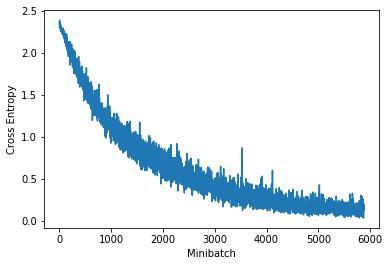

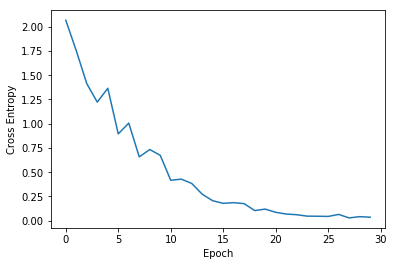

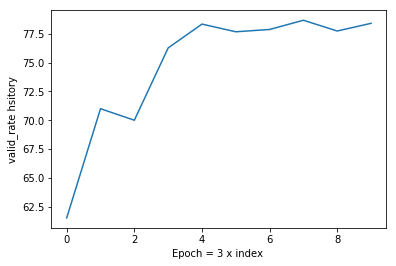

In [0]:
# Hyperparameters
#BATCH_SIZE = 128
#NUM_EPOCHS = 4

minibatch_cost, epoch_cost,valid_history = train(allconv, train_loader, valid_loader,test_loader,valid_per = valid_per)

plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

plt.plot(range(len(valid_history)), valid_history)
plt.ylabel('valid_rate hsitory')
plt.xlabel('Epoch = {} x index '.format(valid_per))
plt.show()
